In [1]:
!pip install --upgrade setuptools
!pip install ez_setup
!pip install gym

In [2]:
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import gymnasium
import math
from matplotlib import rc
import sys
from contextlib import closing
from io import StringIO
import gym
from gym import utils
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import time
from IPython.display import clear_output
from scipy.signal import savgol_filter

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# Enviroment

In [3]:
MAP = [
    "+---------+",
    "|R: :A: :G|",
    "| : : : : |",
    "| :A:A: : |",
    "| : : : : |",
    "|Y: :A:B: |",
    "+---------+",
]

class SafeCab(gym.Env):
    """
    Modified Taxi Problem
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self):
        self.desc = np.asarray(MAP, dtype='c')
        self.locs = locs = [(0,0), (0,4), (4,0), (4,3)]
        self.anomaly_locs = [(0,2), (2,1), (2,2), (4,2)]

        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        num_states = 500
        num_actions = 6

        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Discrete(num_states)

        # Initialize state distribution and transition probabilities
        self.P = {state: {action: [] for action in range(num_actions)} for state in range(num_states)}
        self.initial_state_distrib = np.zeros(num_states)

        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            self.initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # Defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1  # Default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2:
                                new_col = min(col + 1, max_col)
                            elif action == 3:
                                new_col = max(col - 1, 0)
                            elif action == 4:  # Pickup
                                if (pass_idx < 4 and taxi_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else:  # Passenger not at location
                                    reward = -10
                            elif action == 5:  # Dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 1000
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # Dropoff at wrong location
                                    reward = -10

                            new_loc = (new_row, new_col)
                            if new_loc in self.anomaly_locs:
                                reward = -1000
                                done = True
                            new_state = self.encode(new_row, new_col, new_pass_idx, dest_idx)
                            self.P[state][action].append((1.0, new_state, reward, done))

        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        state = self.s
        transitions = self.P[state][action]
        probabilities, next_states, rewards, dones = zip(*transitions)
        next_state = self.np_random.choice(next_states, p=probabilities)
        reward = rewards[next_states.index(next_state)]
        terminated = dones[next_states.index(next_state)]
        truncated = False  # You can set this according to your environment's logic if needed
        self.s = next_state
        return next_state, reward, terminated, truncated, {}

    def reset(self):
        self.s = self.np_random.choice(range(self.observation_space.n), p=self.initial_state_distrib)
        self.lastaction = None
        return self.s

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # Passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')

        for (zx, zy) in self.anomaly_locs:
            out[1 + zx][2 * zy + 1] = utils.colorize(out[1 + zx][2 * zy + 1], 'red', bold=True)

        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        num_rows = 5
        i = taxi_row
        i *= num_rows
        i += taxi_col
        i *= num_rows
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        num_rows = 5
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % num_rows)
        i = i // num_rows
        out.append(i % num_rows)
        i = i // num_rows
        out.append(i)
        assert 0 <= i < num_rows
        return reversed(out)

from gym.envs.registration import register

# Register the environment with gym
register(
    id='SafeCab-v0',
    entry_point='__main__:SafeCab',
    max_episode_steps=100,
)


In [4]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Episode: {frame['episode']}")
        print(f"Timestep: {frame['step']}")    
        print(f"State: {frame['state']}")
        print(f"Reward: {frame['reward']}")
        time.sleep(.4)

In [5]:
env = gym.make('SafeCab-v0')

In [6]:
env.reset()
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: :A: :G|
| : : : : |
| :A:A: : |
| : : : : |
|Y: :A:B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


C:\Users\felip\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
C:\Users\felip\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
C:\Users\felip\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.int32'>`
  logger.warn(
C:\Users\felip\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the envi

In [7]:
env.action_space

Discrete(6)

In [8]:
action_size = env.action_space.n
print("Action size ", action_size)

state_size = env.observation_space.n
print("State size ", state_size)

Action size  6
State size  500


# Q-Learn

In [9]:
class Agent:
  
    def __init__(self, n_states, n_actions, decay_rate=0.0001, learning_rate=0.7, gamma=0.618):
        self.n_actions = n_actions
        self.q_table = np.zeros((n_states, n_actions))
        self.epsilon = 1.0
        self.max_epsilon = 1.0
        self.min_epsilon = 0.01
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.gamma = gamma # discount rate
        self.epsilons_ = []

    def choose_action(self, explore=True):
        exploration_tradeoff = np.random.uniform(0, 1)

        if explore and exploration_tradeoff < self.epsilon:
            # exploration
            return np.random.randint(self.n_actions)    
        else:
            # exploitation (taking the biggest Q value for this state)
            return np.argmax(self.q_table[state, :])
  
    def learn(self, state, action, reward, next_state, done, episode):
        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        self.q_table[state, action] = self.q_table[state, action] + \
            self.learning_rate * (reward + self.gamma * \
                np.max(self.q_table[new_state, :]) - self.q_table[state, action])
    
        if done:
            # Reduce epsilon to decrease the exploration over time
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
            self.epsilons_.append(self.epsilon)

# Training

In [10]:
total_episodes = 60000
total_test_episodes = 10

agent = Agent(env.observation_space.n, env.action_space.n)

In [11]:
untrained_frames = []

for episode in range(total_test_episodes):
    state = env.reset()

    step = 1
    
    while True:
        action = agent.choose_action()
        
        new_state, reward, terminated, truncated, info = env.step(action)        
        
        untrained_frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'episode': episode + 1,
            'step': step,
            'reward': reward
        })
        
        if terminated or truncated:
            step = 0
            break
        state = new_state
        step += 1

C:\Users\felip\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\felip\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'numpy.int32'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")


In [12]:
print_frames(untrained_frames)

+---------+
|R: :A: :G|
| : : : : |
| :A:A: : |
| : : : : |
|Y: :A:B: |
+---------+


Episode: 10
Timestep: 15
State: 431
Reward: -1000


In [13]:
rewards = []

for episode in range(total_episodes):
    state = env.reset()
    episode_rewards = []
    
    while True:
        action = agent.choose_action()
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env.step(action)
        
        done = terminated or truncated
        
        agent.learn(state, action, reward, new_state, done, episode)

        state = new_state
        
        episode_rewards.append(reward)
        
        if done:
            break
          
    rewards.append(np.mean(episode_rewards))

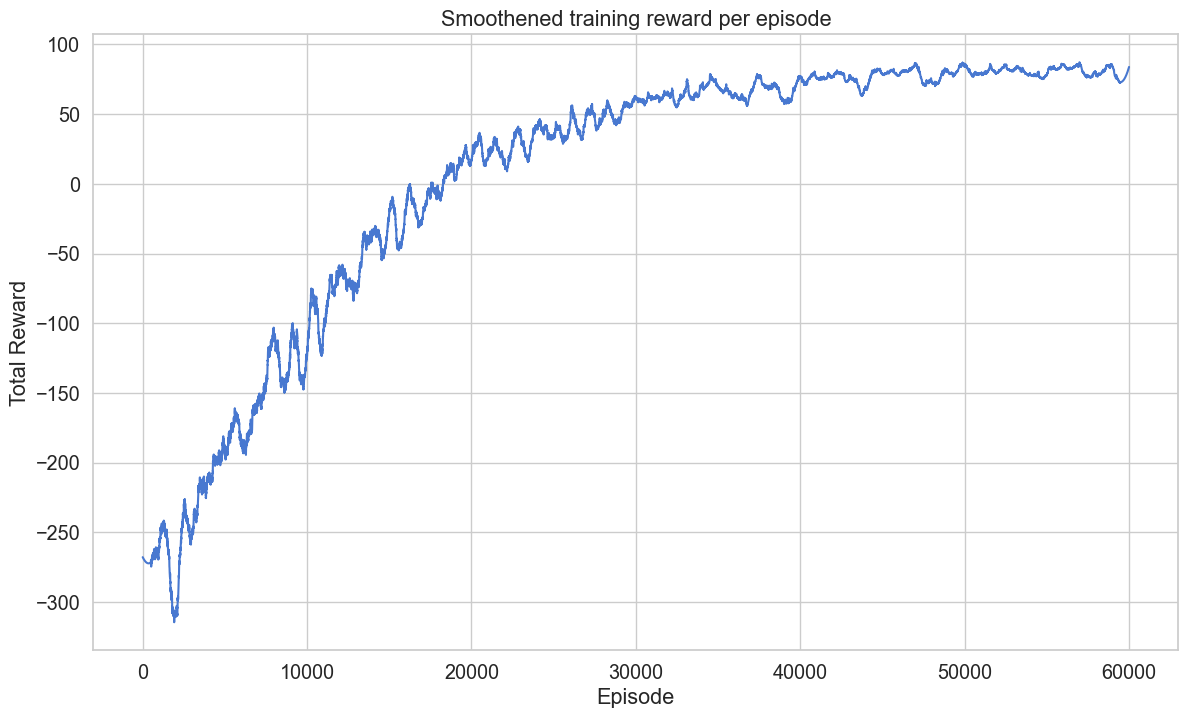

In [14]:
plt.plot(savgol_filter(rewards, 1001, 2))
plt.title("Smoothened training reward per episode")
plt.xlabel('Episode');
plt.ylabel('Total Reward');

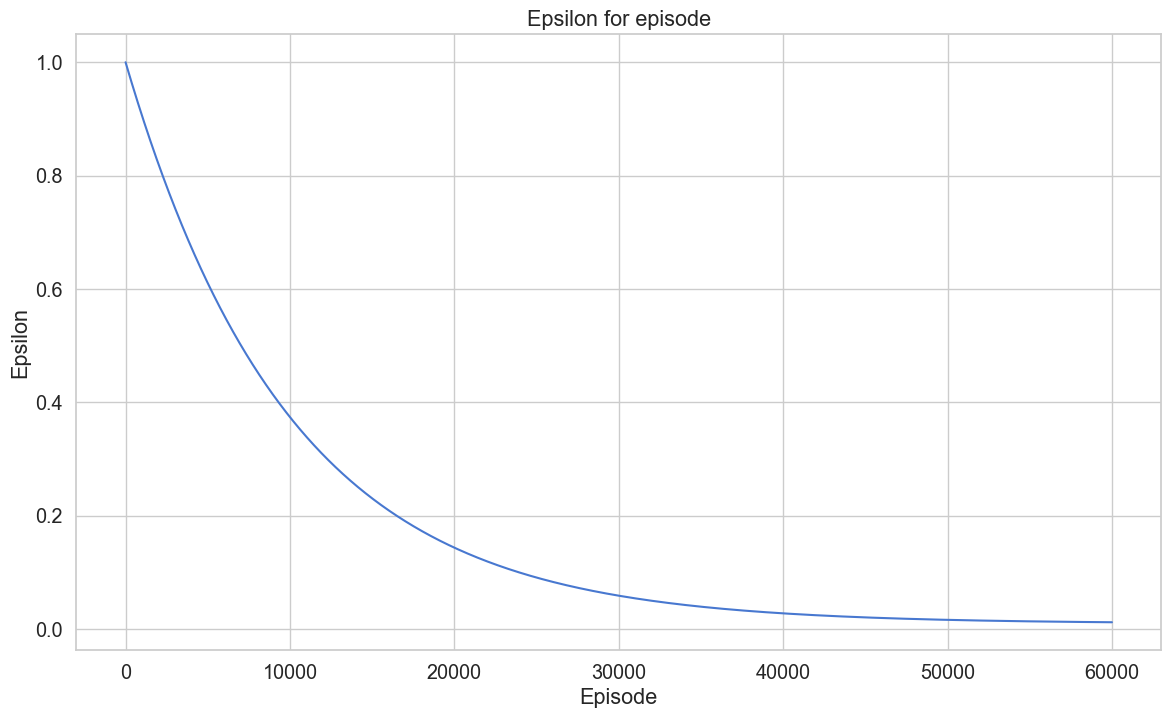

In [15]:
plt.plot(agent.epsilons_)
plt.title("Epsilon for episode")
plt.xlabel('Episode');
plt.ylabel('Epsilon');

# Evaluation

In [16]:
frames = []
rewards = []

for episode in range(total_test_episodes):
    state = env.reset()
    episode_rewards = []

    step = 1
    
    while True:
        action = agent.choose_action(explore=False)
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, terminated, truncated, info = env.step(action)
        
        # Determine if the episode has ended
        done = terminated or truncated
        
        frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'episode': episode + 1,
          'step': step,
          'reward': reward
        })
        
        episode_rewards.append(reward)
        
        if done:
            step = 0
            break
        state = new_state
        step += 1
    
    rewards.append(np.mean(episode_rewards))

env.close()


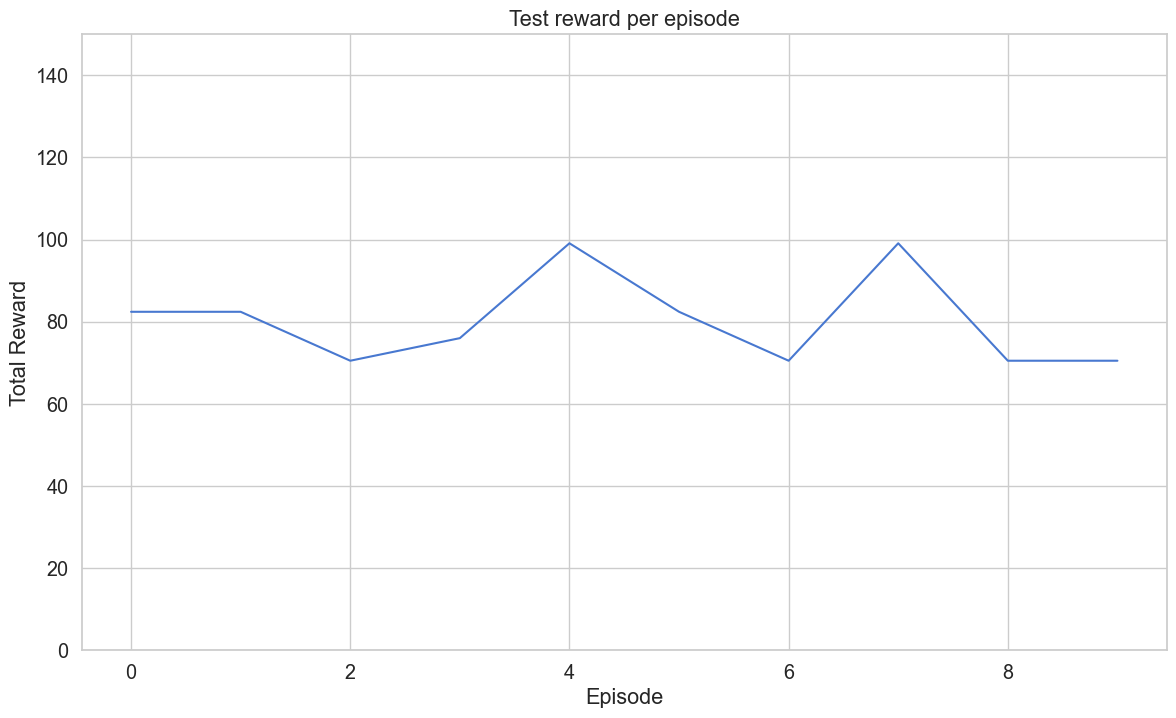

In [17]:
plt.plot(rewards)
plt.title("Test reward per episode")
plt.ylim((0, 150))
plt.xlabel('Episode');
plt.ylabel('Total Reward');

In [18]:
print_frames(frames)

+---------+
|R: :A: :G|
| : : : : |
| :A:A: : |
| : : : : |
|Y: :A:B: |
+---------+


Episode: 10
Timestep: 14
State: 97
Reward: 1000
